In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

pd.options.display.max_rows = 8  
%matplotlib inline

读取数据

In [2]:
national_debt = pd.read_csv('data/national_debt_5y.csv',header=0,index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()
national_debt.describe()

,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078
2016/1/22,2.705,2.689,2.705,2.682,-0.0041
2016/1/25,2.750,2.694,2.750,2.680,0.0019
2016/1/26,2.703,2.738,2.740,2.690,0.0163
2016/1/27,2.763,2.774,2.783,2.763,0.0131


,开盘,收盘,高,低,涨跌幅
count,1563.000000,1563.000000,1563.000000,1563.000000,1.563000e+03
mean,3.041862,3.022280,3.049060,3.010074,4.478567e-07
std,0.419688,0.420101,0.418939,0.420670,9.475657e-03
min,1.740000,1.740000,1.740000,1.740000,-5.850000e-02
25%,2.746000,2.712000,2.750000,2.697000,-4.350000e-03
50%,3.012000,2.993000,3.018000,2.983000,0.000000e+00
75%,3.261000,3.234000,3.269000,3.219000,4.300000e-03
max,4.000000,3.968000,4.000000,3.952000,6.070000e-02


开盘价原始数据可视化

<Figure size 432x288 with 0 Axes>

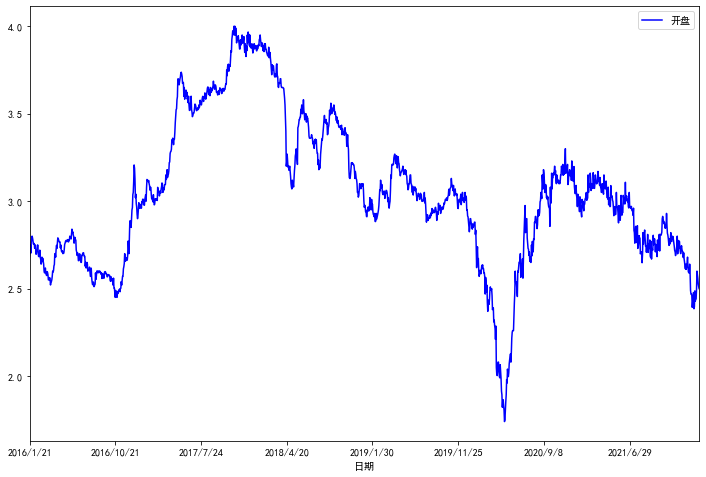

In [3]:
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue',figsize=(12,8))
    plt.show()
    
draw_ts(pd.DataFrame(national_debt['开盘']))

数据预处理

In [4]:
# 前(1563-600=963)天的开盘价作为训练集,表格从0开始计数，,0:1 是提取[0:1)列，前闭后开
training_set = national_debt.iloc[0:1563 - 600,0:].values  

#中间300天的数据作为验证集
valid_set= national_debt.iloc[1563 - 600:1563 - 300, 0:].values  

# 后300天的开盘价作为测试集
test_set = national_debt.iloc[1563 - 300:1563, 0:].values  

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
valid_set = sc.transform(valid_set)
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

#对开盘价数据进行归一化，方便后续可视化展示
sc_for_visual = MinMaxScaler(feature_range=(0, 1))  
y_test_for_visual_scaled = sc_for_visual.fit_transform(national_debt.iloc[0:1563 - 600, 0:1].values ) 
y_test_for_visual = sc_for_visual.transform(national_debt.iloc[1563 - 300:1563, 0:1].values )

得到训练集和测试集的数据

In [5]:
x_train = []
y_train = []

x_valid = []
y_valid = []

x_test = []
y_test = []

# 利用for循环，遍历整个训练集，提取训练集中连续10天的开盘价作为输入特征x_train，第11天的数据作为标签
for i in range(30, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 30:i, 1:]) 
    y_train.append(training_set_scaled[i, 0])


# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 30,4))
print(x_train)

#验证集
for i in range(30, len(valid_set)):
    x_valid.append(valid_set[i - 30:i,1:])
    y_valid.append(valid_set[i, 0])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], 30,4))


# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续10天的开盘价作为输入特征x_train，
# 第11天的数据作为标签，for循环共构建300-10=290组数据。
for i in range(30, len(test_set)):
    x_test.append(test_set[i - 30:i,1:])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合CNN和RNN输入要求：
#RNN: [送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 30,4))


[[[0.18613607 0.16322581 0.18825782 0.49134615]
  [0.17907574 0.16451613 0.18953414 0.37692308]
  [0.18228498 0.19354839 0.18825782 0.43461538]
  ...
  [0.14056483 0.12258065 0.15507339 0.40576923]
  [0.14762516 0.12774194 0.16017869 0.45673077]
  [0.14634146 0.15483871 0.16081685 0.40865385]]

 [[0.17907574 0.16451613 0.18953414 0.37692308]
  [0.18228498 0.19354839 0.18825782 0.43461538]
  [0.21052632 0.18709677 0.19463944 0.57307692]
  ...
  [0.14762516 0.12774194 0.16017869 0.45673077]
  [0.14634146 0.15483871 0.16081685 0.40865385]
  [0.15468549 0.14193548 0.16975112 0.46346154]]

 [[0.18228498 0.19354839 0.18825782 0.43461538]
  [0.21052632 0.18709677 0.19463944 0.57307692]
  [0.23363286 0.21483871 0.24122527 0.54230769]
  ...
  [0.14634146 0.15483871 0.16081685 0.40865385]
  [0.15468549 0.14193548 0.16975112 0.46346154]
  [0.15853659 0.14387097 0.17102744 0.43846154]]

 ...

 [[0.31643132 0.29870968 0.32227186 0.43269231]
  [0.30680359 0.29225806 0.32099553 0.36634615]
  [0.31771

训练模型

In [10]:
model = tf.keras.Sequential([
    LSTM(30, return_sequences=True), #第一层记忆体的个数为50个，每个时间步推送ht到下一层
    Dropout(0.2),
    LSTM(50),  #第二层
    Dropout(0.2),
    Dense(1) #输出知识ht+1的股票开盘价，所以是1
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

#该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
checkpoint_save_path = "./checkpoint/LSTM/LSTM_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_valid, y_valid), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./data/weights_of_nation_debt_by_lstm.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()


Epoch 1/50
15/15 [==============================] - 3s 191ms/step - loss: 0.1117 - val_loss: 0.0294
Epoch 2/50
15/15 [==============================] - 1s 68ms/step - loss: 0.0188 - val_loss: 0.0124
Epoch 3/50
15/15 [==============================] - 1s 66ms/step - loss: 0.0104 - val_loss: 0.0071
Epoch 4/50
15/15 [==============================] - 1s 69ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 5/50
15/15 [==============================] - 1s 67ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 6/50
15/15 [==============================] - 1s 56ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 7/50
15/15 [==============================] - 1s 49ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 8/50
15/15 [==============================] - 1s 67ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 9/50
15/15 [==============================] - 1s 62ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 10/50
15/15 [==============================] - 1s 65ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 11

28

9

7925

38

10

491

26

7

1951

28

10

490

38

10

491

26

7

3251

17

8

751

15

5

13

Text(0.5, 1.0, 'Training and Validation Loss')

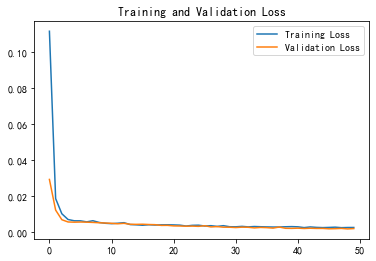

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss') #验证集用来选则最佳的超参数的值
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'national debt Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'national debt Price')

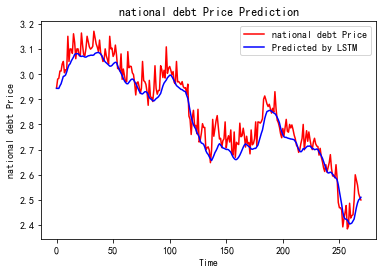

均方误差: 0.002548
均方根误差: 0.050481
平均绝对误差: 0.038206


In [14]:
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)

# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc_for_visual.inverse_transform(predicted_stock_price)

# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc_for_visual.inverse_transform(y_test_for_visual[30:])
# 画出真实数据和预测数据的对比曲线
# 画出真实数据和预测数据的对比曲线
plt.figure(facecolor='white')
plt.plot(real_stock_price, color='red', label='national debt Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted by LSTM')
plt.title('national debt Price Prediction')
plt.xlabel('Time')
plt.ylabel('national debt Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

In [13]:
from sklearn.metrics import explained_variance_score
import seaborn as sns

cm = explained_variance_score(real_stock_price, predicted_stock_price)


print(cm )

0.9538037388747974
